In [1]:
using DataFrames, Gadfly
using Vec, LinearAlgebra
using GridWorldPathFollowing
using GraphUtils

┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /home/kylebrown/.julia/packages/Gadfly/09PWZ/src/mapping.jl:228


In [42]:
function plot_traj_with_steps(traj,grid_path;Δt=0.01,pad=0.01)
    t_range = get_start_time(traj):Δt:get_end_time(traj)
    cw = grid_path.cellwidth/2 - pad
    xpts = [map(w->w.pt.x, grid_path.waypoints)..., grid_path.start_pt.x]
    ypts = [map(w->w.pt.y, grid_path.waypoints)..., grid_path.start_pt.y]
    plot(
        layer( x=[get_position(traj,t).x for t in t_range], y=[get_position(traj,t).y for t in t_range],
            Geom.path, Theme(default_color="black") ),
        layer( x=[get_start_pt(seg).x for seg in traj.segments], y=[get_start_pt(seg).y for seg in traj.segments],
            size=[8pt], Geom.point, Theme(default_color="red") ),
        layer( x=[get_end_pt(seg).x for seg in traj.segments], y=[get_end_pt(seg).y for seg in traj.segments],
            size=[8pt],Geom.point, Theme(default_color="yellow") ),
        layer( xmin=xpts .- cw, xmax=xpts .+ cw, ymin=ypts .- cw, ymax=ypts .+ cw, Geom.rect ),
        Coord.cartesian(fixed=true)
    )
end
function compare_velocity_profiles(traj1,traj2;Δt=0.05)
    t0 = max(get_start_time(traj1),get_start_time(traj2))
    tf = min(get_end_time(traj1),get_end_time(traj2))
    @assert t0 < tf "trajectories do not overlap"
    t_vec = collect(get_start_time(base_traj):Δt:get_end_time(base_traj))
    df = DataFrame(
        t=t_vec, 
        v1=[norm(get_vel(traj1,t)) for t in t_vec],
        v2=[norm(get_vel(traj2,t)) for t in t_vec],
    )
    plot(
        layer(df,x="t",y="v2",Geom.path,Theme(default_color="red")),
        layer(df,x="t",y="v1",Geom.path,Theme(default_color="black")),
        Guide.manual_color_key("",["v1","v2"],["black","red"])
    )
end
function plot_vel_and_yaw_rate(traj;Δt=0.1)
    t_vec = collect(get_start_time(traj):Δt:get_end_time(traj))
    df = DataFrame(
        t=t_vec, 
        theta=[atan(get_heading(traj,t)) for t in t_vec],
        s=[get_dist(traj,t) for t in t_vec], 
        v=[norm(get_vel(traj,t)) for t in t_vec] )
    vstack( plot(df,x="t", y="theta",Geom.path), 
        plot(df,x="t",y="v",Geom.path,Theme(default_color="red")) )
end
function plot_accel_vel_pos(base_traj,traj,t_vec,accel,vel,pos)
    df = DataFrame(
        t = t_vec,
        a = [accel..., 0.0],
        v = vel,
        v1=map(t->norm(get_vel(base_traj,t)),t_vec),
        s = pos
    )
    df2 = DataFrame(
        t = [[get_start_time(seg) for seg in traj.segments]..., get_end_time(traj)],
        s = [0, cumsum([get_length(seg) for seg in traj.segments])...]
    )
#     vstack(
        plot(
            layer(df,x="t",y="a",Geom.step,Theme(default_color="green")),
            layer(df,x="t",y="v",Geom.path,Theme(default_color="red")),
            layer(df,x="t",y="v1",Geom.path,Theme(default_color="black")),
            Guide.manual_color_key("",["accel","vel_opt","vel"],["green","red","black"])
        )
#         plot(
#             layer(df,x="t",y="s",Geom.path,Theme(default_color="blue")),
#             layer(df2,x="t",y="s",Geom.point,Theme(default_color="orange")),
#             Guide.manual_color_key("",["distance","constraints"],["blue","orange"])
#         )
#     )
end
function summarize_simulation(traj,states,cmds,time_vec)
    if length(time_vec) < length(states)
        time_vec = [time_vec..., 2*time_vec[end]-time_vec[end-1]]
    end
    errors = Vector{Vector{Float64}}()
    for (t,state) in zip(time_vec,states)
        target_pt = get_trajectory_point_by_time(traj, t)
        target = [target_pt.pos.x, target_pt.pos.y, atan(target_pt.heading)]
        push!(errors, [target[1]-state[1],target[2]-state[2],get_angular_offset(state[3],target[3])])
    end
    df = DataFrame(
        t=time_vec,
        w=[map(u->u[1],cmds)...,0.0],
        v=[map(u->u[2],cmds)...,0.0],
        wr=map(t->get_yaw_rate(traj,t),time_vec),
        vr=map(t->norm(get_vel(traj,t)),time_vec),
        x=map(s->s[1],states[1:length(time_vec)]),
        y=map(s->s[2],states[1:length(time_vec)]),
        θ=map(s->wrap_to_pi(s[3]),states[1:length(time_vec)]),
        xr=map(t->get_position(traj,t).x,time_vec),
        yr=map(t->get_position(traj,t).y,time_vec),
        θr=map(t->atan(get_heading(traj,t)),time_vec),
        ex=map(e->e[1],errors),
        ey=map(e->e[2],errors),
        eθ=map(e->e[3],errors)
    )
    hstack(
            vstack(
                plot(
                    layer(df,x="x",y="y",Geom.path,Theme(default_color="blue")),
                    layer(x=[states[1][1]],y=[states[1][2]],Geom.point,Theme(default_color="blue")),
                    layer(df,x="xr",y="yr",Geom.path,Theme(default_color="red")),
                    layer(x=[get_position(traj,time_vec[1]).x],
                        y=[get_position(traj,time_vec[1]).y],Geom.point,Theme(default_color="red")),
                    Coord.Cartesian(fixed=true),
                    Guide.manual_color_key("",["true","ref"],["blue","red"])
                )
            ),
            vstack(
                plot(
                    layer(df,x="t",y="w",Geom.path,Theme(default_color="red")),
                    layer(df,x="t",y="wr",Geom.path,Theme(default_color="black")),
                    Guide.manual_color_key("",["w","wref"],["red","black"]) ),
                plot(
                    layer(df,x="t",y="v",Geom.path,Theme(default_color="blue")),
                    layer(df,x="t",y="vr",Geom.path,Theme(default_color="black")),
                    Guide.manual_color_key("",["v","vref"],["blue","black"]) ),
                plot(
                    layer(df,x="t",y="ex",Geom.path,Theme(default_color="blue")),
                    layer(df,x="t",y="ey",Geom.path,Theme(default_color="red")),
                    layer(df,x="t",y="eθ",Geom.path,Theme(default_color="green")),
                    Guide.manual_color_key("",["ex","ey","eθ"],["blue","red","green"]) )
            )
        )
end

summarize_simulation (generic function with 1 method)

In [43]:
start_pt = VecE2(0.0,0.0)
start_time = 0.0
action_sequence = [SOUTH,EAST,WAIT,NORTH,EAST,WAIT,WAIT,EAST,EAST,SOUTH,SOUTH,WEST,NORTH,WEST,SOUTH,WEST,WEST]
# action_sequence = [EAST,WAIT,NORTH,EAST]
cell_width = 1.0
transition_time = 2.0
grid_path = construct_grid_world_path(start_pt,start_time,action_sequence,cell_width,transition_time)

base_traj = construct_trajectory(grid_path)
verify(base_traj)
# Optimize Velocity Profile
traj, t_vec, accel, vel, pos = optimize_velocity_profile(base_traj;a_max=1.25);
verify(traj);

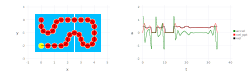

In [44]:
set_default_plot_size(25cm,8cm)
hstack(
    plot_traj_with_steps(base_traj,grid_path),
    plot_accel_vel_pos(base_traj,traj,t_vec,accel,vel,pos)
)

# Closed-loop tracking of Trajectory with optimized speed profile

In [45]:
sim_model = UnicycleModel()
# controller = TrackingController(k0=2.0,k1=2.0)
controller = SwitchingController()
t0 = 0.0
tf = get_end_time(traj)
dt = 0.05
state_pt = get_trajectory_point_by_time(traj, t0)
initial_state = [state_pt.pos.x, state_pt.pos.y, atan(state_pt.heading)] + .1*(1 .- rand(3))
states, cmds = simulate(sim_model,controller,traj,initial_state,t0,tf,dt)

time_vec = collect(t0:dt:tf);

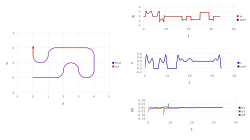

In [46]:
set_default_plot_size(25cm,14cm)
summarize_simulation(traj,states,cmds,time_vec)

# Tracking stationary spinning paths--does it work?

In [47]:
c = VecE2(0.0,0.0)
r = 0.0
θ1 = 0.0
w = 1.0
dt = 1.0
T = 4
traj = Trajectory([ArcTrajectory(c,r,θ1+w*(t-1)*dt,w*dt,TimeInterval(dt*(t-1),dt*t)) for t in 1:T])
verify(traj)

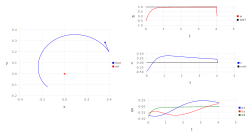

In [48]:
sim_model = UnicycleModel()
controller = SwitchingController()
t0 = 0.0
tf = get_end_time(traj)
dt = 0.05
state_pt = get_trajectory_point_by_time(traj, t0)
initial_state = [state_pt.pos.x, state_pt.pos.y, atan(state_pt.heading)] + 1.0*rand(3)
states, cmds = simulate(sim_model,controller,traj,initial_state,t0,tf,dt)

time_vec = collect(t0:dt:tf)
set_default_plot_size(25cm,14cm)
summarize_simulation(traj,states,cmds,time_vec)

# Track a Multi-Stage Composite Path with a turn-in-place in the middle

In [49]:
function stitch_trajectories(traj1::Trajectory,traj2::Trajectory;buffer=[0.0,0.0])
    @assert norm(get_end_pt(traj1) - get_start_pt(traj2)) < 0.000001 "start and end points do not align"
    @assert buffer[1]+buffer[2] <= get_start_time(traj2) - get_end_time(traj1)
    θ1 = atan(get_heading(traj1,get_end_time(traj1)))
    θ2 = atan(get_heading(traj2,get_start_time(traj2)))
    Δθ = get_angular_offset(θ1,θ2)
    traj = Trajectory()
    for seg in traj1.segments
        push!(traj, seg)
    end
    push!(traj, WaitTrajectory(
        get_end_pt(traj), 
        get_heading(traj,get_end_time(traj)),
        TimeInterval(get_end_time(traj),get_end_time(traj)+buffer[1])) 
        )
    push!(traj, PivotTrajectory(
        get_end_pt(traj),
        get_heading(traj,get_end_time(traj)),
        Δθ,TimeInterval(get_end_time(traj),get_start_time(traj2)-buffer[2]))
        )
    push!(traj, WaitTrajectory(
        get_end_pt(traj), 
        get_heading(traj,get_end_time(traj)), 
        TimeInterval(get_end_time(traj),get_start_time(traj2)))
        )
    for seg in traj2.segments
        push!(traj, seg)
    end
    return traj
end

stitch_trajectories (generic function with 1 method)

In [50]:
cell_width = 1.0
transition_time = 2.0
grid_path1 = construct_grid_world_path(VecE2(0.0,0.0),0.0,
    [SOUTH,EAST,WAIT,NORTH],cell_width,transition_time)
traj1 = construct_trajectory(grid_path1)
Δt = 2.0 # time between end of traj1 and start of traj2
grid_path2 = construct_grid_world_path(get_end_pt(traj1),get_end_time(traj1)+Δt,
    [EAST,SOUTH,EAST,WAIT,NORTH],cell_width,transition_time)
traj2 = construct_trajectory(grid_path2)

base_traj = stitch_trajectories(traj1,traj2;buffer=[0.1,0.1])
verify(base_traj)

traj, t_vec, accel, vel, pos = optimize_velocity_profile(base_traj;a_max=1.25);

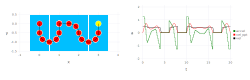

In [51]:
set_default_plot_size(25cm,8cm)
hstack(
    plot_traj_with_steps(base_traj,GridWorldPath( grid_path1.start_pt, grid_path1.start_time,
            vcat(grid_path1.waypoints,grid_path2.waypoints),cell_width )),
    plot_accel_vel_pos(base_traj,traj,t_vec,accel,vel,pos)
)

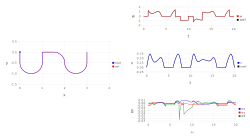

In [52]:
sim_model = UnicycleModel()
controller = SwitchingController(pivoter=PivotController(kw=0.5,kp=2.0))
t0 = 0.0
tf = get_end_time(traj)
dt = 0.05
state_pt = get_trajectory_point_by_time(traj, t0)
initial_state = [state_pt.pos.x, state_pt.pos.y, atan(state_pt.heading)] + 0.01*rand(3)
states, cmds = simulate(sim_model,controller,traj,initial_state,t0,tf,dt)

time_vec = collect(t0:dt:tf)
set_default_plot_size(25cm,14cm)
summarize_simulation(traj,states,cmds,time_vec)

# Test PivotController with position offset

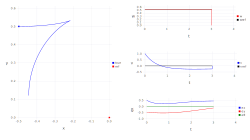

In [54]:
t0 = 0.0; tf = 3.0; dt=0.01;
state = [-0.5,0.5,0.0]
Δθ = π/2
traj = PivotTrajectory(VecE2(0.0,0.0),VecE2(1.0,0.0),Δθ,TimeInterval(t0,tf))
controller = PivotController(kw=0.5,kp=2.0)

time_vec = collect(t0:dt:tf)
states, cmds = simulate(sim_model,controller,traj,state,t0,tf,dt);
set_default_plot_size(25cm,14cm)
summarize_simulation(traj,states,cmds,time_vec)

# Test StabilizeController

In [187]:
function GridWorldPathFollowing.get_action(controller::StabilizeController,target::Vector{Float64},ff::Vector{Float64},state::Vector{Float64},t::Float64)
    # println("get_action(controller::StabilizeController,target::Vector{Float64},ff::Vector{Float64},state::Vector{Float64},t::Float64)")
    kw = controller.kw
    kp = controller.kp
    kϕ = 15.0
    # state (global frame)
    x,y,θ = state[1],state[2],state[3]
    # reference (global frame)
    xr,yr,θr = target[1],target[2],target[3]
    wr,vr = ff[1],ff[2]
    # control law
    dx = xr-x
    dy = yr-y
    dp = dot([dx,dy],[cos(θ),sin(θ)]) # distance to target position projected onto heading vector
    dθ = ([cos(θ),sin(θ),0] × [cos(θr),sin(θr),0])[end] # heading error
    ϕ = atan(dy,dx)
    dϕ = ([cos(θ),sin(θ),0] × [cos(ϕ),sin(ϕ),0])[end] # angular displacement from target position
    w = wr + kϕ*dϕ*norm([dx,dy]) + kw*dθ
    w = wr + kϕ*dϕ*dp + kw*dθ
    v = vr + kp*dp
    return [w, v]
end

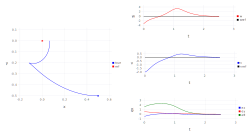

In [196]:
t0 = 0.0; tf = 2.5; dt=0.01;
state = [0.5,-0.5,0]
traj = WaitTrajectory(VecE2(0.0,0.0),VecE2(0.0,1.0),TimeInterval(t0,tf))
controller = StabilizeController(kw=2.0,kp=4.0)

time_vec = collect(t0:dt:tf)
states, cmds = simulate(sim_model,controller,traj,state,t0,tf,dt);
set_default_plot_size(25cm,14cm)
summarize_simulation(traj,states,cmds,time_vec)

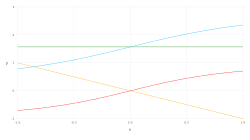

In [171]:
xr = 0.0
yr = 0.0
θr = π/2

xvec = collect(-1.0:.1:1.0)
yvec = -1.0*ones(length(xvec))
θvec = (π/2)*ones(length(xvec))

idxs = collect(1:length(xvec))
dx = xr .- xvec
dy = yr .- yvec
dp = map(i->dot([dx[i],dy[i]],[cos(θvec[i]),sin(θvec[i])]),idxs) # distance to target position projected onto heading vector
dθ = map(θ->-([cos(θ),sin(θ),0] × [cos(θr),sin(θr),0])[end],θvec) # heading error
ϕ = map(i->atan(VecE2(dx[i],dy[i])),idxs)
dϕ = map(i->([cos(θvec[i]),sin(θvec[i]),0] × [cos(ϕ[i]),sin(ϕ[i]),0])[end],idxs)
plot(
    layer(x=xvec,y=ϕ,Geom.path),
    layer(x=xvec,y=dx,Geom.path,Theme(default_color="orange")),
    layer(x=xvec,y=dϕ,Geom.path,Theme(default_color="red")),
    layer(x=xvec,y=θvec,Geom.path,Theme(default_color="green")),
#     layer(x=xvec,y=map(i->get_angular_offset(θvec[i],ϕ[i]),idxs),Geom.path,Theme(default_color="green"))
)

In [138]:
[0,1,0] × [1,0,0]

3-element Array{Int64,1}:
  0
  0
 -1

In [148]:
i = idxs[1]
[cos(θvec[i]),sin(θvec[i]),0] × [cos(ϕ[i]),sin(ϕ[i]),0]

3-element Array{Float64,1}:
  0.0               
  0.0               
 -0.7071067811865476